In [1]:
from __future__ import division
import graphlab

In [2]:
products = graphlab.SFrame('amazon_baby_subset.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to pukaracharya2052@gmail.com and will expire on July 25, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1505240740.log


In [3]:
import json
with open('important_words.json', 'r') as f: 
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

# Remote punctuation
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

products['review_clean'] = products['review'].apply(remove_punctuation)

# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [5]:
train_data, validation_data = products.random_split(.9, seed=1)

print 'Training set  : %d data points' % len(train_data)
print 'Validation set: %d data points' % len(validation_data)

Training set  : 47780 data points
Validation set: 5292 data points


In [6]:
import numpy as np

def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [12]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

In [13]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1. / (1.+np.exp(-score))    
    return predictions

In [14]:
def feature_derivative(errors, feature): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors, feature)

    return derivative

In [15]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)
    
    return lp

In [16]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions        
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print "Gradient single data point: %s" % gradient_single_data_point
print "           --> Should print 0.0"

Gradient single data point: 0.0
           --> Should print 0.0


In [17]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions        
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print "Gradient mini-batch data points: %s" % gradient_mini_batch
print "                --> Should print 1.0"

Gradient mini-batch data points: 1.0
                --> Should print 1.0


In [18]:
print len(sentiment_train)

47780


In [19]:
from math import sqrt
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]
    
    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions = predict_probability(feature_matrix[i:i+batch_size,:], coefficients)
        
        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        ### YOUR CODE HERE
        indicator = (sentiment[i:i+batch_size]==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            ### YOUR CODE HERE
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j])
            
            # compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
            coefficients[j] += (1./batch_size)*(step_size * derivative)
        
        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print 'Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp)
        
        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0
                
    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [20]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print '-------------------------------------------------------------------------------------'
print 'Coefficients learned                 :', coefficients
print 'Average log likelihood per-iteration :', log_likelihood
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print '-------------------------------------------------------------------------------------'
    print 'Test passed!'
else:
    print '-------------------------------------------------------------------------------------'
    print 'Test failed'

Iteration 0: Average log likelihood (of data points in batch [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points in batch [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


In [21]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=1, max_iter=10)


Iteration 0: Average log likelihood (of data points in batch [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points in batch [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points in batch [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points in batch [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points in batch [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points in batch [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points in batch [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points in batch [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points in batch [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points in batch [00009:00010]) = -0.00000124


In [22]:
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, 
                                        batch_size = len(feature_matrix_train), 
                                        max_iter=200)

Iteration   0: Average log likelihood (of data points in batch [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points in batch [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points in batch [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points in batch [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points in batch [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points in batch [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points in batch [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points in batch [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points in batch [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points in batch [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points in batch [00000:47780]) = 

In [23]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [01000

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')
    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

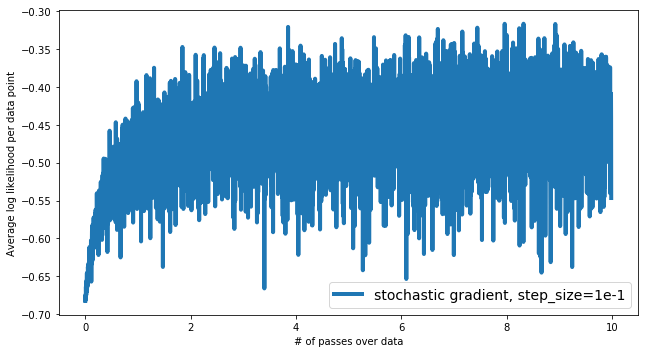

In [25]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

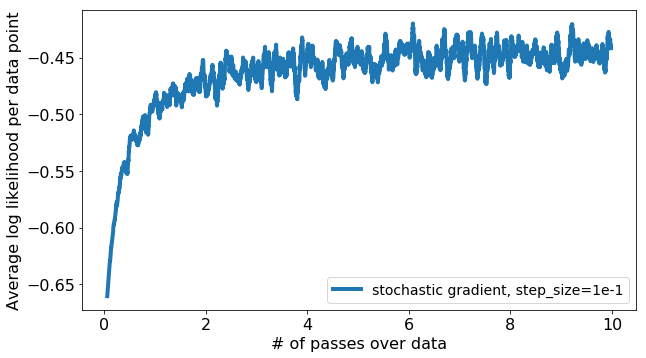

In [26]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

In [27]:
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

## YOUR CODE HERE
coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points in b

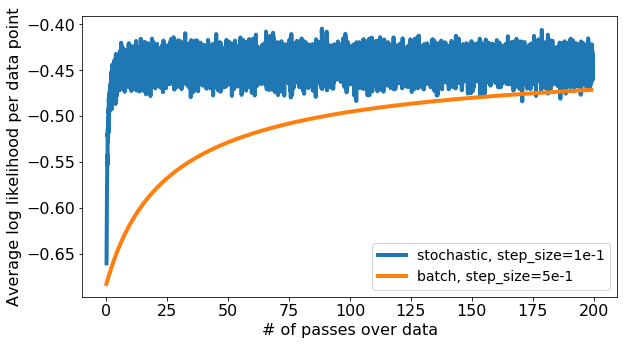

In [28]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

In [29]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points in batch [01000

/home/hell_raider/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/hell_raider/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Iteration  300: Average log likelihood (of data points in batch [30000:30100]) = -3.83037593
Iteration  400: Average log likelihood (of data points in batch [40000:40100]) = -3.14931563
Iteration  500: Average log likelihood (of data points in batch [02300:02400]) = -4.80508816
Iteration  600: Average log likelihood (of data points in batch [12300:12400]) = -17.33121209
Iteration  700: Average log likelihood (of data points in batch [22300:22400]) = -8.33353486
Iteration  800: Average log likelihood (of data points in batch [32300:32400]) = -4.52307543
Iteration  900: Average log likelihood (of data points in batch [42300:42400]) = -3.04990545
Iteration 1000: Average log likelihood (of data points in batch [04600:04700]) = -2.84706421
Iteration 2000: Average log likelihood (of data points in batch [09200:09300]) = -4.51026105
Iteration 3000: Average log likelihood (of data points in batch [13800:13900]) = -1.69532123
Iteration 4000: Average log likelihood (of data points in batch [1840

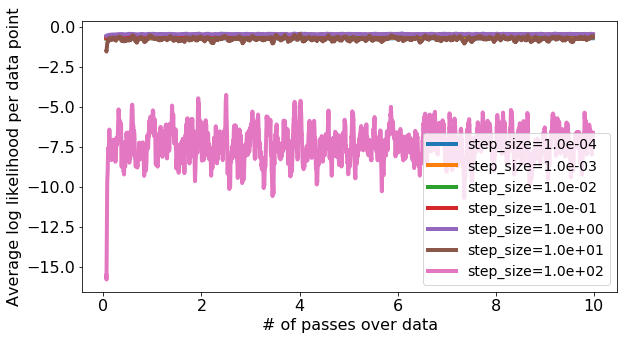

In [30]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

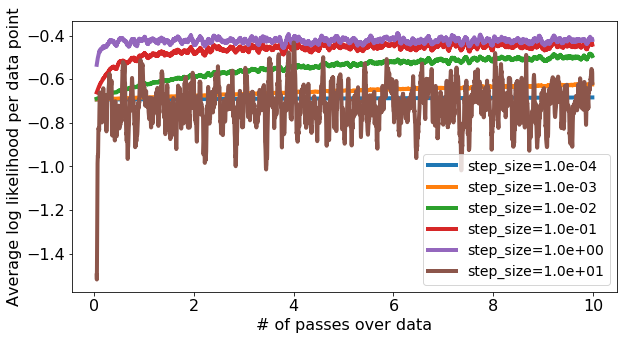

In [31]:
for step_size in np.logspace(-4, 2, num=7)[0:6]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)
